# [실습 2] BERT 모델을 이용한 의류 리뷰 감성 분석

## 실습 목표

---

1. 파이썬 라이브러리를 활용하여 텍스트 데이터를 전처리합니다.

2. Pytorch 라이브러리를 이용하여 BERT 모델을 구현하고, 이를 학습시켜 결과를 확인합니다.

3. Hugging Face에서 불러온 모델과 결과를 비교해봅니다.

# 의류 리뷰 분석을 위한 Pytorch BERT 구현하기

## 1. 모듈 불러오기 및 환경 설정

실습 과정에 필요한 라이브러리를 불러옵니다.  

각 라이브러리에 대해 간략하게 설명하겠습니다.  

- `os`: 운영체제와 상호작용할 수 있는 함수들을 제공

- `re`: 정규 표현식(regular expression)을 지원하는 라이브러리로, 문자열 패턴 매칭 등에 사용

- `math`: 수학적 연산을 제공하는 라이브러리

- `numpy as np`: 고성능 수치 계산을 위한 라이브러리로, 다차원 배열과 수학 함수를 제공

- `pandas as pd`: 데이터 분석과 조작을 위한 라이브러리로, 표 형태의 데이터를 다루는데 편리한 기능을 제공

- `from random import *`: Python의 기본적인 난수(random number) 관련 함수들을 포함한 라이브러리

- `from tqdm import tqdm`: 반복 작업에 진행 상태를 시각적으로 보여주는 프로그레스 바를 제공

- `from itertools import chain`: 반복 가능한(iterable) 객체들을 하나로 연결하는 데 사용되는 라이브러리

- `from collections import Counter`: 컨테이너에 저장된 요소들의 개수를 셀 수 있는 카운터 객체를 제공

- `import warnings`: 경고 메시지를 관리하고 출력하는 라이브러리

- `seaborn as sns`: Matplotlib을 기반으로 다양한 테마와 색상 팔레트를 제공하여 데이터 시각화를 편리하게 만들어주는 라이브러리

- `import matplotlib.pyplot as plt`: 데이터를 시각화하기 위한 라이브러리로, 그래프를 그리는데 사용

- `import nltk`: 자연어 처리를 위한 라이브러리(Natural Language Toolkit)로, 토큰화, 형태소 분석 등의 자연어 처리 기능을 제공

- `import pdb`: 파이썬 디버깅 도구인 pdb(Debugger for Python)를 import

- `import torch`: 파이토치는 딥러닝 프레임워크로, 텐서 연산과 뉴럴 네트워크를 구현에 필요

- `import torch.nn as nn`: 파이토치에서 제공하는 뉴럴 네트워크 모듈

- `import torch.optim as optim`: 파이토치에서 제공하는 최적화 알고리즘을 사용하기 위해 optim 모듈을 import합니다.

- `from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler`: 파이토치에서 데이터를 다루기 위한 유틸리티 함수

- `from sklearn.model_selection import train_test_split`: scikit-learn에서 제공하는 데이터 분할 함수로, 데이터를 학습용과 테스트용으로 나누는데 사용

- `from sklearn.metrics import accuracy_score`: scikit-learn에서 제공하는 정확도 계산 함수로, 예측 결과와 실제 결과를 비교하여 정확도를 계산

In [ ]:
import re
import math
import numpy as np
import pandas as pd
from random import *
from tqdm import tqdm
from itertools import chain
from collections import Counter

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import pdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



Pytorch에서는 GPU를 활용하기 위해 Device 설정을 해줘어야 합니다.  

아래 코드를 실행하여 `device`변수에 GPU 활용 여부를 할당합니다.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. 데이터 불러오기 및 전처리

이번 실습에 사용될 데이터는 Kaggle에서 제공되는 [여성 의류 리뷰 데이터](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)입니다.  

해당 데이터는 csv(Comma-Seperated Value)형식으로 저장되어있으며, 온라인 쇼핑몰에서 소비자들의 정보와 이들이 남긴 리뷰 및 평점이 기록되어있습니다.  

데이터에는 23486개의 샘플에 대한 10가지 특징변수 있습니다.  

각 샘플은 소비자의 리뷰에 대응하며, 10가지 특징변수에는 의류 ID, 작성자의 연령, 리뷰 제목, 리뷰 본문, 평점, 추천 여부와 리뷰가 받은 추천 수 등 다양한 항목이 포함되어 있습니다.  

우리는 이 중 리뷰를 바탕으로 평점을 예측하는 모델을 만들어보겠습니다.

In [ ]:
path = '/content/Womens Clothing E-Commerce Reviews.csv'

데이터 경로에서 csv파일을 불러와 Pandas Dataframe으로 읽어보겠습니다.  

`head()`메서드로 상위 5개 샘플만 확인해볼까요?

In [ ]:
raw_df = pd.read_csv(path)
raw_df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


리뷰 분석을 통한 평점 예측에 많은 자료가 필요하지는 않습니다.  

우리는 이 중 후기에 해당하는 `Review Text`열과, 이에 대응하는 점수 `Rating`열  두 가지만 필요합니다.  

우선 인덱싱을 통해 `Review Text`열과 `Rating`열의 첫 번째 항목을 확인해보겠습니다.

### [TODO] 데이터 중 `Review Text`열과 `Rating`열의 첫 번째 항목을 확인해봅시다.

In [ ]:
raw_df['Review Text'][0]

'Absolutely wonderful - silky and sexy and comfortable'

In [ ]:
raw_df['Rating'][0]

4

데이터프레임의 `info()`메서드를 사용하면 각 컬럼 별 항목의 수와, 항목 내 자료들의 타입을 확인할 수 있습니다.  

만일 수치 이외의 다양한 형태의 자료가 섞여있다면, Dtype은 object로 표시됩니다.

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


### 2.1 데이터 결측치 처리

위의 통계치를 보면 다소 이상한 부분이 존재합니다.  

전체 데이터의 샘플 수는 앞서 말씀드렸듯 23486행으로 구성되어있다고 말씀드렸습니다.  

그러나 위의 몇 컬럼은 이보다 적은 수의 데이터(Non-Null Count)를 보유하고 있습니다.  

특히, 우리가 사용할 컬럼인 `Review_Text`에도 몇 가지 결측치가 있을 것으로 보입니다.  

우선 우리가 사용할 컬럼만 슬라이싱을 통해 `df`라는 변수에 할당하겠습니다.  

In [ ]:
df = raw_df[['Review Text', 'Rating']]
df.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5


데이터가 분리되었다면, 결측치를 시각화해봅시다.  

`isnull()`은 데이터프레임의 각 요소가 결측값인지 여부를 True(결측값) 또는 False(결측값이 아님)로 나타내는 데이터프레임을 반환합니다.  

이렇게 Bool type으로 구성된 데이터프레임을 히트맵으로 표현해보겠습니다.  

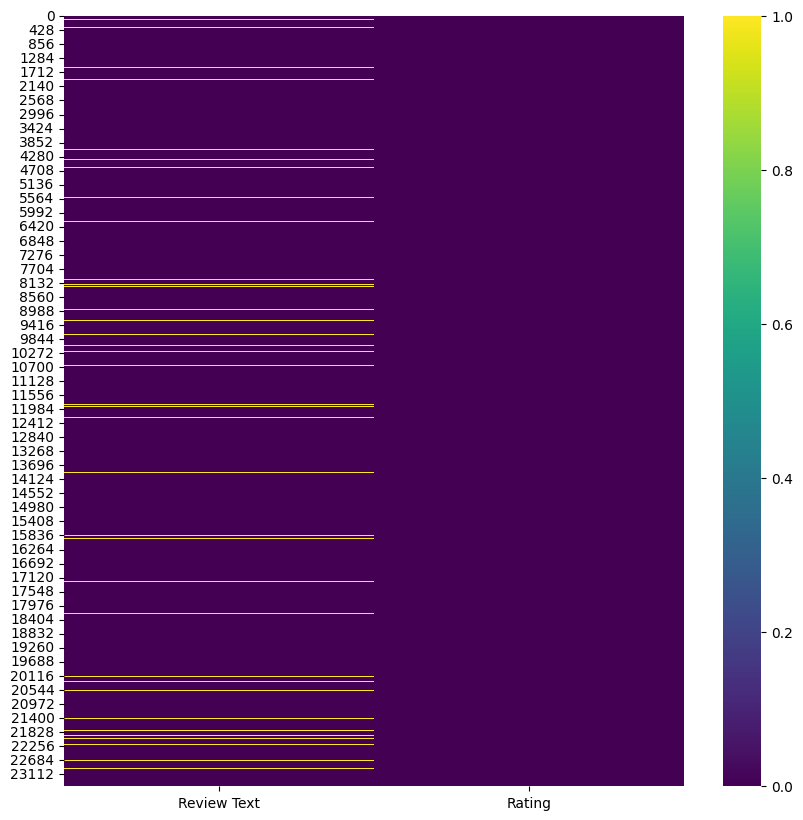

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(), cmap='viridis')
plt.show()

생각보다 결측치가 많으며, 데이터 전역에 골고루 퍼져있습니다.  

결측치를 제거하기 위해 정확한 결측치의 수 파악이 필요합니다.  

`isnull()` 메서드를 호출하여 각 셀에 대해 결측치 여부를 판별할 수 있습니다.  

원본 데이터프레임과 동일한 형태의 데이터프레임에 결측치가 있는 부분은 True, 그렇지 않은 부분은 False로 표현되어 반환됩니다.  

이에 `sum()`메서드를 사용하면 컬럼 별로 True의 수를 합쳐 반환합니다.  

In [ ]:
df.isnull().sum()

Review Text    845
Rating           0
dtype: int64

결측치가 상당히 많이 발견됩니다.  

이제 정확한 수를 파악했으니, 결측치를 제거하여 올바르게 데이터가 정제되는지 확인하갰습니다.  

`df.dropna()` 메서드는 데이터프레임에서 비어있는 행을 제거합니다.  

`inplace=True`인자는 데이터가 제거된 후 행 인덱스를 업데이트해 줍니다.

### [TODO] 데이터프레임에 `dropna()`메서드를 적용하여 결측치를 제거해봅시다.  

inplace 인자를 조절하여 데이터프레임의 인덱스를 재조정해주세요.

In [ ]:
df.dropna(inplace=True)

df.isnull().sum()

Review Text    0
Rating         0
dtype: int64

### 2.2 중복 데이터 제거
비어있는 데이터가 있었다면, 중복되는 데이터도 있지 않나 의심이 됩니다.  

이번엔 `duplicated()`메서드를 통해 중복된 샘플을 반환해보겠습니다.

In [ ]:
duplicated_df = df.duplicated()
print(df[duplicated_df])

                                             Review Text  Rating
10067  Perfect fit and i've gotten so many compliment...       5
11074  Lightweight, soft cotton top and shorts. i thi...       5
12526  I purchased this and another eva franco dress ...       2
13354  Perfect fit and i've gotten so many compliment...       5
14275  I bought this shirt at the store and after goi...       5
21470  The sweater and skirt are so pretty! they're r...       5
21888  Love, love these jeans. being short they come ...       5


중복된 데이터도 다소 발견이 되는군요.  

이를 `df.drop_duplicates()` 메서드로 제거해 보겠습니다.

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### 2.3 텍스트 정제

데이터의 중복을 제거했다면, 이번엔 각 리뷰를 전처리하겠습니다.  

리뷰 전처리 과정에는 아래 항목들이 포함됩니다.

- 소문자 변환

- HTML 태그 제거

- 알파벳 이외 기호 제거

- 불용어 제거  

우선 불용어 제거를 위해 NLTK에서 영어 불용어 데이터를 다운받도록 하겠습니다.

In [ ]:
nltk.download('stopwords')
stopwords = set( nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


이어, 위의 네 가지 기능이 포함된 전처리 함수를 선언해보도록 하겠습니다.  

1. 소문자 변환: `lower()`메서드를 사용하면 텍스트를 소문자로 변환합니다.

2. HTML 태그 제거: `re.sub` 메서드를 사용하여 `<>`패턴이 반복되는 모든 HTML 태그를 제거합니다.  

3. 알파벳 제외 기호 제거: 마찬가지로 `re.sub` 메서드를 사용하여 알파벳을 제외한 모든 기호를 공백으로 대체합니다.  

4. 불용어 제거: 단어 리스트 중 불용어 명단에 없는 단어만 사용합니다.

### [TODO] 텍스트 데이터 전처리 함수를 완성해주세요.  

코드 우측에 있는 주석을 이용하여 함수의 빈 칸을 채워주세요.

In [ ]:
def text_preprocessing(text):
    # 소문자 변환
    text = text.lower()
    # HTML 태그 제거
    text = re.sub('<.*?>', '', text)
    # 알파벳 제외 기호 제거
    text = re.sub('[^a-zA-Z]', ' ', text)
    # 불용어 제거
    text = [word for word in text.split() if word not in stopwords]
    text = ' '.join(text)
    return text

전처리 함수를 실제 리뷰에 한 번 적용해보도록 합시다.

In [ ]:
sample = df['Review Text'][1]
print(sample)
print('='*20)
print(text_preprocessing(sample))

Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petite love length hits little knee would definitely true midi someone truly petite


위 문장과 비교했을 떄, 특수문자와 숫자가 모두 사라진 것을 확인할 수 있습니다.  

또한 모든 대문자가 소문자로 변환되었고, 일부 단어는 아예 사라진 것도 확인 가능합니다.

이 정도면 충분하니, 함수를 데이터프레임에 적용하여, 변환된 텍스트를 새로 생성된 `cleaned_review` 컬럼에 옮겨봅시다.  

In [ ]:
df['cleaned_review'] = df['Review Text'].apply(text_preprocessing)
df.head()

,Review Text,Rating,cleaned_review
0,Absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,5,love dress sooo pretty happened find store gla...
2,I had such high hopes for this dress and reall...,3,high hopes dress really wanted work initially ...
3,"I love, love, love this jumpsuit. it's fun, fl...",5,love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,5,shirt flattering due adjustable front tie perf...


### 2.4 레이블 수정
현재 각 후기에 대한 평점은 데이터프레임의 `Rating` 컬럼에 저장되어 있습니다.  

1에서 5 사이의 값으로 표현된 것 같습니다만, 전체 평점의 분포를 확인해보면 정확하게 파악할 수 있겠지요?  

`Seaborn` 라이브러리의 `countplot()`을 사용하면 데이터의 갯수를 세어 히스토그램(도수분포표)으로 표현할 수 있습니다.

<Axes: xlabel='Rating', ylabel='count'>

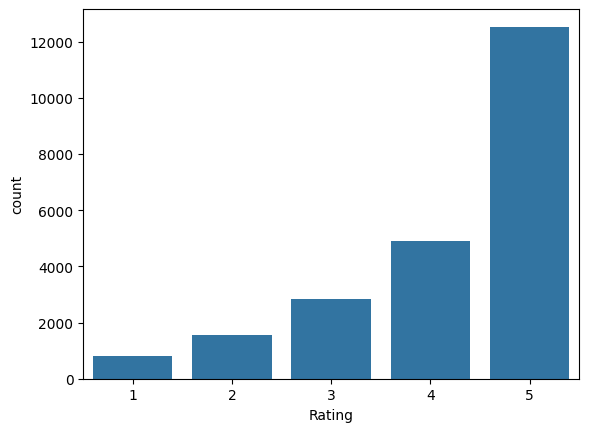

In [ ]:
sns.countplot(x=df['Rating'])

예상했던 대로 레이블은 5개가 존재합니다.  

다만 대부분의 데이터가 5에 편중되어 있어, 이대로 학습을 시킬 시 불균형한 데이터로 인하여 학습에 지장이 생길 수 있습니다.  

데이터를 추가적으로 구하는 것은 어렵고, 데이터를 downsampling하여 일부 데이터를 학습에서 배제시키기엔 소수 데이터의 양이 너무 적습니다.  

우선 1-3점에 해당하는 데이터를 부정적인(Negative) 리뷰로, 4-5점에 해당하는 데이터를 긍정적인 리뷰로 간주하여 이를 이분화해보겠습니다.  

이 경우 데이터프레임을 필터링하여 슬라이싱할 경우 특정 기준치를 바탕으로 데이터프레임을 변환할 수 있습니다.

### [TODO] 아래 데이터의 `Rating`을 3.5 기준으로 나누어 변환해봅시다.  

- 비교 연산자를 사용하여 `Rating` 항목이 3.5보다 큰 값을 True로 반환합시다.  

- astype()메서드를 사용하여 Boolean 타입을 정수형 데이터로 변환합니다.

In [ ]:
df['Rating'] = (df['Rating'] > 3.5).astype(int)

df.head()

,Review Text,Rating,cleaned_review
0,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happened find store gla...
2,I had such high hopes for this dress and reall...,0,high hopes dress really wanted work initially ...
3,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,1,shirt flattering due adjustable front tie perf...


### 2.5 단어 빈도수 확인

리뷰 중 어떤 단어가 가장 많이 사용되었는지 확인해봅시다.  

모델의 용량이 작거나 단어가 지나치게 많은 경우 일반적으로 많이 사용되는 단어를 선별하여 학습시키고, 나머지 단어는 사용하지 않는 토큰(`[UNK]`) 처리를 합니다.  

BERT 모델의 경우 학습할 수 있는 단어의 수가 많고, 이번 데이터셋에서 사용되는 단어의 가지 수가 다양하지 않으므로 이번 실습에는 모든 단어를 전부 학습할 예정입니다.  

그러나 여러분들께서 더 다양한 모델을 실험하시거나 데이터의 범주가 훨씬 많은 도메인을 다룰 땐 사용할 단어를 선정해주셔야 합니다.  

그러한 상황에서 아래 코드와 같이 단어의 빈도를 확인해보는 것은 기준치를 설정하기에 좋은 방법입니다.

In [ ]:
corpus = [word for text in df['cleaned_review'] for word in text.split()]

count_words = Counter(corpus)


sorted_words = count_words.most_common()
sorted_words

[('dress', 10565),
 ('love', 8947),
 ('size', 8772),
 ('top', 7416),
 ('fit', 7322),
 ('like', 7147),
 ('wear', 6437),
 ('great', 6116),
 ('would', 5107),
 ('fabric', 4798),
 ('small', 4726),
 ('color', 4605),
 ('look', 4037),
 ('really', 3924),
 ('ordered', 3846),
 ('little', 3775),
 ('perfect', 3772),
 ('one', 3636),
 ('flattering', 3520),
 ('well', 3390),
 ('soft', 3340),
 ('back', 3247),
 ('comfortable', 3059),
 ('cute', 3042),
 ('nice', 3024),
 ('bought', 2984),
 ('beautiful', 2964),
 ('looks', 2875),
 ('bit', 2866),
 ('fits', 2856),
 ('large', 2842),
 ('shirt', 2823),
 ('material', 2765),
 ('much', 2709),
 ('length', 2679),
 ('also', 2587),
 ('sweater', 2549),
 ('long', 2466),
 ('got', 2420),
 ('jeans', 2401),
 ('colors', 2382),
 ('petite', 2365),
 ('waist', 2355),
 ('quality', 2297),
 ('medium', 2281),
 ('xs', 2220),
 ('pretty', 2193),
 ('think', 2185),
 ('even', 2172),
 ('retailer', 2160),
 ('work', 2122),
 ('tried', 2083),
 ('store', 2025),
 ('usually', 2008),
 ('skirt', 1975)

이중 가장 많이 사용된 단어들을 상위 20개만큼 추출하여 그래프로 표현하겠습니다.  

가로축은 단어, 세로축은 빈도를 표현합니다.

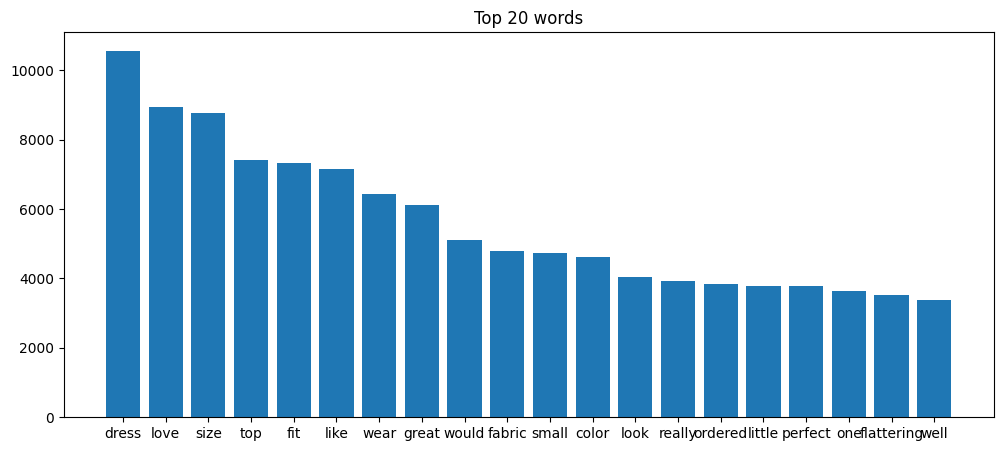

In [ ]:
keys = []
values = []

for key, value in sorted_words[:20]:

    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 words')
plt.show()

상위 20개의 단어가 추출되었습니다.  

dress 라는 단어는 10000번 이상 사용되었지만, 20위인 well이라는 단어는 이의 절반보다 적은 횟수로 사용되었습니다.  

이번에는 전체 단어들의 빈도 분포를 히스토그램으로 표현해보겠습니다.  

우선 단어의 빈도에 대한 리스트를 numpy array로 바꾸어 이를 Pyplot의 `hist()`함수로 도수분포표 형식에 맞춰 시각화시키겠습니다.

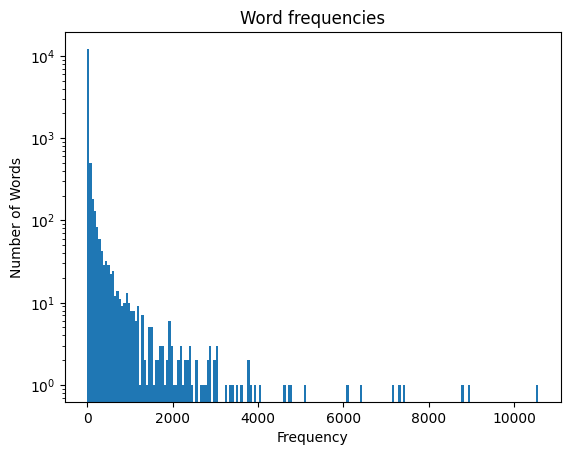

In [ ]:
frequencies = np.array([freq for word, freq in sorted_words])

plt.hist(frequencies, bins = 200, log = True)
plt.title('Word frequencies')
plt.xlabel('Frequency')
plt.ylabel('Number of Words')
plt.show()

주로 대부분의 단어가 1000번 이하의 빈도로 사용된 것을 볼 수 있습니다.

### 2.5 토큰화
데이터의 기본적인 정제와 빈도 시각화를 마쳤다면, 토큰화를 시켜 데이터를 수치로 변환시켜보겠습니다.  

우선은 데이터 처리를 위해 리스트 헝태로 바꿔주겠습니다.

### [TODO] 아래 두 데이터프레임을 리스트로 변환시켜주세요.

In [ ]:
reviews = df['cleaned_review'].tolist()
ratings = df['Rating'].tolist()

> 예시코드
```
reviews = df['cleaned_review'].tolist()
ratings = df['Rating'].tolist()
```

토큰화를 위한 함수를 선언해줍니다.  

`create_vocab_and_tokenize` 함수는 주어진 리뷰 데이터를 기반으로 토큰화하고, 이를 통해 어휘를 만들며, 각 리뷰를 모델 입력 형태로 변환합니다.  

작동 순서는 아래와 같습니다.  

1. `tokenize_text`: 각 리뷰를 띄어쓰기 기준으로 토큰화하는 내부 함수입니다.  


2. 모든 리뷰를 토큰화합니다.

3. 각 토큰의 발생 횟수를 카운트하여 어휘를 생성합니다. `min_freq`보다 적게 등장하는 토큰은 제외됩니다.  

4. 특수 토큰들 (`[PAD], [UNK], [CLS], [SEP]`)을 어휘에 추가합니다.

5. 각 리뷰를 어휘를 이용해 ID로 변환하고, 입력 ID와 attention mask를 생성합니다. 리뷰는 `[CLS]`로 시작하고 `[SEP]`로 끝나며, max_length를 초과하는 부분은 잘립니다. 또한 max_length보다 짧은 경우 `[PAD]`로 패딩 처리됩니다.

함수의 반환 값은 총 세 가지입니다.

- `vocab`: 토큰과 해당 토큰의 ID를 매핑한 단어 사전입니다.

- `input_ids`: 모든 리뷰의 토큰화된 ID 리스트입니다.

- `attention_masks`: 각 리뷰의 attention mask 리스트입니다. 패딩된 부분은 0, 아닌 부분은 1의 값을 가집니다.

### [TODO] 토큰화를 위한 함수를 완성시켜주세요.

전반적인 순서는 위에 나와있는 절차를 따라 주시면 됩니다.

헷갈리시는 부분은 코드 상 주석을 참조하여 빈 칸을 채워주세요.

In [ ]:
def create_vocab_and_tokenize(reviews, min_freq=0, max_length=64):
    # 리뷰를 토큰화합니다.
    def tokenize_text(text):
        return text.split()

    tokenized_reviews = [tokenize_text(review) for review in reviews]

    # 각 토큰의 발생 횟수를 세어봅니다.
    token_counts = Counter(chain(*tokenized_reviews))

    # min_freq 이상 출현한 토큰만으로 어휘를 만듭니다.
    vocab = {token: i for i, (token, count) in enumerate(token_counts.items()) if count >= min_freq}

    #어휘에 특수 토큰을 추가합니다
    vocab = {**{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3}, **vocab}

    # 리뷰를 입력 ID와 attention masks로 변환합니다.
    input_ids = []
    attention_masks = []

    for review in reviews:
        # 리뷰를 토큰화하고 최대 길이에 맞게 잘라냅니다.
        tokens = tokenize_text(review)[:max_length-2]
        input_id = [2] + [vocab.get(token, 1) for token in tokens] + [3]
        attention_mask = [1] * len(input_id) + [0] * (max_length - len(input_id))
        input_id += [0] * (max_length - len(input_id))
        input_ids.append(input_id)
        attention_masks.append(attention_mask)

    return vocab, torch.tensor(input_ids), torch.tensor(attention_masks)

> 예시코드
```
def create_vocab_and_tokenize(reviews, min_freq=0, max_length=64):
    # 리뷰를 토큰화합니다.
    def tokenize_text(text):
        return text.split()

    tokenized_reviews = [tokenize_text(review) for review in reviews]

    # 각 토큰의 발생 횟수를 세어봅니다.
    token_counts = Counter(chain(*tokenized_reviews))

    # min_freq 이상 출현한 토큰만으로 어휘를 만듭니다.
    vocab = {token: i for i, (token, count) in enumerate(token_counts.items()) if count >= min_freq}

    # 어휘에 특수 토큰을 추가합니다.
    vocab = {**{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3}, **vocab}

    # 리뷰를 입력 ID와 attention masks로 변환합니다.
    input_ids = []
    attention_masks = []

    for review in reviews:
        # 리뷰를 토큰화하고 최대 길이에 맞게 잘라냅니다.
        tokens = tokenize_text(review)[:max_length-2]
        # 토큰을 ID로 변환하고, 앞뒤로 [CLS]와 [SEP] 토큰을 추가합니다.
        input_id = [2] + [vocab.get(token, 1) for token in tokens] + [3]
        # attention mask를 생성합니다.
        attention_mask = [1] * len(input_id) + [0] * (max_length - len(input_id))
        # 입력 ID를 max_length에 맞게 [PAD] 토큰으로 채웁니다.
        input_id += [0] * (max_length - len(input_id))
        input_ids.append(input_id)
        attention_masks.append(attention_mask)

    return vocab, torch.tensor(input_ids), torch.tensor(attention_masks)
```

위의 함수를 바탕으로 단어사전과 인덱스 리스트, attention mask 리스트를 생성합니다.  

생성된 데이터들은 모델의 입력에 필요하므로 `.to(device)` 메서드를 통해 GPU로 이동시킵니다.

데이터의 전처리를 마쳤다면, `Dataset`을 생성합니다.  

`Dataset`과 `DataLoader`는 PyTorch의 데이터 처리 및 로딩 파이프라인에 있어 핵심적인 두 구성 요소입니다.

- `Dataset`: 데이터와 해당 데이터에 대한 접근 방식을 정의합니다. 이를 통해 데이터의 구조와 로딩 방식을 캡슐화하며, 이를 다른 기능(예: 데이터 전처리)에서 재사용하기 쉽게 만듭니다.

- `DataLoader`: `Dataset`에서 제공하는 데이터를 어떻게 배치로 만들고 처리할지 정의합니다. 즉, 데이터 로딩과 전처리를 멀티 프로세스로 병렬 처리할 수 있게 해주므로, GPU 훈련 중에 CPU에서 데이터를 준비하는 동안 대기 시간을 최소화 할 수 있습니다.

Dataset이 만들어졌다면, 이를 바탕으로 DataLoader을 만듭니다.

Dataloader은 배치 단위로 데이터를 분할해주기 때문에, batch size를 선언해줄 수 있습니다.

### [TODO] Dataloader를 생성해주세요.

학습용 Dataloader와 검증 Dataloader를 생성해주세요.

Dataloader에는 Dataset, Sampler, batch_size 등이 인자로 들어가게 됩니다. 코드의 빈 칸을 채워주세요.

> 예시코드
```
# 배치의 크기를 설정합니다.
batch_size = 64

# 훈련 데이터를 위한 DataLoader를 생성합니다. 이때 무작위 샘플링을 사용하여 각 에폭마다 데이터를 무작위로 섞습니다.
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),  # 무작위 샘플링
            batch_size = batch_size
        )

# 검증 데이터를 위한 DataLoader를 생성합니다. 여기서는 순차적 샘플링을 사용하여 데이터 순서를 그대로 유지합니다.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),  # 순차적 샘플링
            batch_size = batch_size
        )
```

## 3. 모델 구현
이번엔 BERT 모델을 구현해보도록 하겠습니다.  

모델은 `Torch.nn.Module`을 상속받은 클래스로 선언하겠습니다.  

이에 앞서 모델의 구성에 필요한 하이퍼파라미터를 설정하겠습니다.  



### 3.1 활성화 함수 선언

이 함수는 GELU(Gaussian Error Linear Unit)라는 활성화 함수를 구현한 것입니다.  

GELU는 BERT와 같은 트랜스포머 모델에서 자주 사용되며, 다른 활성화 함수보다 깊은 신경망에서 잘 동작하는 것으로 알려져 있습니다.

### 3.2 Embedding layer 클래스 선언

아래는 BERT 모델의 임베딩 레이어를 구현한 것입니다. 임베딩 레이어는 두 가지 주요한 부분으로 구성됩니다:

- 토큰 임베딩(`tok_embedding`): 주어진 입력 토큰(단어나 문자)을 고정된 크기의 벡터로 변환합니다. 이 벡터는 모델이 학습하는 과정에서 업데이트됩니다.

- 위치 임베딩(`pos_embedding`): 트랜스포머 아키텍처는 순차적인 정보를 자동으로 처리하지 않기 때문에, 각 토큰의 위치 정보를 제공하기 위해 위치 임베딩을 사용합니다.

이 두 임베딩은 합쳐져서 각 토큰에 대한 최종 임베딩 벡터를 생성합니다. 그 후, LayerNorm과 Dropout을 통해 임베딩 벡터가 정규화되고, 과적합을 방지하기 위해 일부 노드가 무작위로 0으로 설정됩니다.

### 3.3 Attention과 QKV

- 쿼리(Query):

퀴리는 현재 주목하고 있는 토큰 또는 정보의 표현입니다. 어텐션 메커니즘에서는 퀴리를 사용하여 다른 모든 토큰 또는 정보와의 관계를 평가합니다.
예를 들어, "나는 ___ 좋아한다"라는 문장에서 빈칸을 채우려 할 때, "나는"이 퀴리가 될 수 있습니다.

- 키(Key):

키는 다른 모든 토큰 또는 정보의 표현입니다. 퀴리와 각 키 사이의 유사도를 계산하여 어떤 토큰 또는 정보에 주목할지 결정합니다.
위의 예에서, 가능한 빈칸의 후보들(예: "사과", "축구", "노래") 각각이 키가 될 수 있습니다.

- 값(Value):

값은 키와 연관된 실제 정보나 페이로드입니다. 어텐션 메커니즘에서는 퀴리와 키 사이의 유사도를 기반으로 각 값에 가중치를 부여하고, 이 가중치를 사용하여 가중 평균된 값을 출력합니다.
위의 예에서, 각 후보에 대한 추가 정보나 설명이 값이 될 수 있습니다.

- 셀프 어텐션(Self attention):

셀프 어텐션은 입력 시퀀스의 각 토큰에 대해 동일한 시퀀스 내의 다른 모든 토큰과의 관계를 계산하는 방식입니다.  

이를 통해 문장 내의 각 단어가 문장의 다른 부분과 어떻게 상호작용하는지를 파악할 수 있습니다.  

셀프 어텐션 연산은 아래와 같이 진행됩니다.  

쿼리(Query), 키(Key), 값(Value) 생성:

1. 먼저, 입력 시퀀스의 각 토큰에 대해 쿼리, 키, 값 표현을 생성합니다. 이는 주어진 입력에 대해 선형 변환을 수행함으로써 이루어집니다.

```
self.w_q = nn.Linear(d_model, d_model)
self.w_k = nn.Linear(d_model, d_model)
self.w_v = nn.Linear(d_model, d_model)
```


2. 어텐션 스코어 계산:

각 쿼리와 모든 키 사이의 유사도(주로 내적)를 계산합니다. 이렇게 계산된 스코어는 어떤 토큰들이 현재 주목하고 있는 토큰과 관련이 깊은지를 나타냅니다.

```
energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
```

3. 스코어 정규화 및 소프트맥스 적용:

계산된 스코어를 정규화합니다. 주로 스코어를 특정 값(예: sqrt(d_model))으로 나누어 스케일링합니다. 그 후, 소프트맥스 함수를 적용하여 각 스코어를 확률 값으로 변환합니다.

```
attention = self.dropout(self.softmax(energy))
```

4. 값 가중치 부여 및 합산:

소프트맥스로 얻은 확률 값을 각 값에 곱하여 가중치를 부여합니다. 그런 다음, 모든 가중치가 부여된 값들을 합산하여 셀프 어텐션의 출력을 생성합니다.

```
x = torch.matmul(attention, V)
```

5. 출력 선형 변환:

마지막으로, 어텐션 출력을 추가적인 선형 변환을 통해 최종 결과를 얻습니다.

```
x = self.fc(x)
```

### 3.4 Multihead attention 클래스 선언

트랜스포머 계열의 모델에서 가장 중요한 부분을 꼽으라면, 망설임 없이 멀티 헤드 어텐션 메커니즘이라고 할 수 있습니다.  

멀티 헤드 어텐션은 트랜스포머 아키텍처의 핵심 구성 요소 중 하나로, 셀프 어텐션(Self-Attention) 메커니즘을 여러 번 동시에 수행하는 방식입니다.  

입력 데이터의 다양한 부분에 주목하여 정보를 집계하는 데 사용되며, 특히나 복잡한 패턴과 관계를 학습하는 데 매우 유용합니다

초기화 부분: 쿼리(Q), 키(K), 값(V)에 대한 선형 변환을 정의합니다. 이 변환은 입력 데이터를 여러 '헤드'로 분할하여 각 헤드에서 어텐션을 계산하는 데 사용됩니다.

순전파 부분:

1. 쿼리, 키, 값에 대한 선형 변환을 수행합니다.

2. 멀티 헤드 어텐션을 위해 데이터를 여러 헤드로 분할합니다.

3. 각 헤드에서 어텐션 스코어를 계산하고, 필요한 경우 마스크를 적용합니다.

4. 어텐션 가중치를 계산하고, 이를 사용하여 값 행렬과 곱하여 어텐션 출력을 얻습니다.
5. 모든 헤드의 출력을 연결하고, 추가적인 선형 변환을 수행합니다.

중간에 멀티 헤드 어텐션을 위해 차원을 변환하는 과정이 있습니다.

`permute()`는 텐서의 차원을 재배열하는 함수로, 여기서 `permute(0, 2, 1, 3)`를 사용하는 이유는 멀티 헤드 어텐션을 계산하기 위해 텐서의 차원을 적절하게 재배열하기 위함입니다.

원래 텐서의 차원은 `[batch_size, seq_len, n_heads, d_model // n_heads]`입니다. 여기서:

- `batch_size`: 배치 크기

- `seq_len`: 시퀀스 길이

- `n_heads`: 어텐션 헤드의 수

- `d_model`: 모델의 차원

permute(0, 2, 1, 3)를 사용하면 차원의 순서가 [batch_size, n_heads, seq_len, d_model // n_heads]로 변경됩니다.  

이렇게 차원을 재배열하면, 각 어텐션 헤드는 독립적으로 시퀀스에 대한 어텐션을 계산할 수 있습니다. 그리고 이렇게 계산된 결과를 다시 원래의 차원 순서로 변경하여 최종 결과를 얻을 수 있습니다.


### 3.5 Positionwise Feedforward Network

PositionwiseFeedforward 네트워크는 트랜스포머 아키텍처의 각 인코더와 디코더 레이어에 포함되어 있습니다. 이 네트워크는 기본적으로 두 개의 선형 변환을 연속적으로 적용하는데, 여기서는 1D Convolution을 사용하여 이 변환을 수행합니다.

초기화 부분: 두 개의 1D Conv 레이어를 정의합니다. 첫 번째 합성곱은 `d_model` 차원의 입력을 `d_ff` 차원으로 확장하고, 두 번째 합성곱은 그 결과를 다시 `d_model` 차원으로 축소합니다.

순전파 부분:

1. 입력 x의 차원을 변경하여 Convolution을 적용하기 적합한 형태로 만듭니다.

2. 첫 번째 합성곱 레이어와 GELU 활성화 함수를 적용한 후, 결과에 드롭아웃을 적용합니다.

3. 두 번째 Convolution 레이어를 적용합니다.

4. 결과의 차원을 원래대로 변경하여 출력합니다.

이 네트워크는 멀티헤드 어텐션의 출력에 비선형 변환을 추가하여 모델의 표현력을 높이는 역할을 합니다.

### 3.6 Encoder layer

트랜스포머 아키텍처의 인코더 레이어를 구현한 클래스입니다.  

각 인코더 레이어는 앞서 선언한 두 가지 주요 구성 요소로 이루어져 있습니다:
- 멀티 헤드 셀프 어텐션

- Position-wise feedforward network

초기화 부분:

- `MultiHeadAttention`: 멀티헤드 셀프 어텐션을 수행합니다. 이는 입력 시퀀스 내의 각 토큰이 다른 모든 토큰과 어떻게 상호작용하는지를 파악합니다.

- `PositionwiseFeedforward`: 네트워크를 통해 추가적인 비선형 변환을 수행합니다.

- `LayerNorm`: 레이어 정규화는 각 레이어의 출력을 안정화하여 학습을 도와줍니다.

- `Dropout`: 과적합을 방지하기 위한 드롭아웃입니다.

순전파 부분:

- 멀티헤드 셀프 어텐션을 적용한 후, 그 결과와 원래의 입력을 더하고 레이어 정규화를 수행합니다. (잔여 연결 및 레이어 정규화)

- Position-wise Feed forward를 적용한 후, 그 결과와 이전 단계의 출력을 더하고 다시 레이어 정규화를 수행합니다.

이 구조는 BERT 인코더의 각 레이어에서 반복적으로 사용되며, 여러 레이어를 쌓아 복잡한 패턴과 관계를 학습할 수 있게 합니다.


### [TODO] `EncoderLayer` 클래스 코드를 완성해주세요.

`EncoderLayer`에는 앞서 선언된 네 가지 클래스를 불러와, 이들 간의 연산을 진행하는 클래스로 구성됩니다. 아래 코드의 빈 칸을 채워주세요.

> 예시코드
```
class EncoderLayer(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_self_attn = MultiHeadAttention()
        self.encoder_feed_fwd = PositionwiseFeedforward()
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, input, input_mask=None):
        # input => [batch_size, seq_len, d_model]

        encoder_outputs = self.layer_norm(input + self.dropout(self.encoder_self_attn(input, input, input, input_mask)))
        encoder_outputs = self.layer_norm(encoder_outputs + self.dropout(self.encoder_feed_fwd(encoder_outputs)))
        return encoder_outputs
```

### 3.7 이번 실습에서 사용된 BERT와 원본 모델과의 차이

이번 실습은 분류에 포커스가 맞춰져있기에, 원본 모델과 다소 차이가 있습니다.

1. PositionwiseFeedforward:

원본 모델에서는 Linear layer(Fully-connected layer)을 통해 연산하지만, 이번 실습에서는 1D Convolution layer를 통해 이 부분을 대체합니다.  

1D Convolution layer을 사용하면 시계열의 특성을 자세하게 읽어낼 수 있을 뿐만 아니라, Linear layer에 비해 적은 파라미터로 연산할 수 있습니다.

2. 모델 출력부분 차이

원본 BERT 모델은 주로 두 가지 출력을 제공합니다:

- Sequence Output: 입력 토큰의 각각에 대한 출력을 포함하는 것으로, 이것은 다운스트림 태스크(예: 토큰 수준의 분류)에 사용될 수 있습니다.

- Pooled Output: 첫 번째 토큰([CLS])에 대한 출력으로, 문장 수준의 분류와 같은 다운스트림 태스크에 주로 사용됩니다. 이 출력은 추가적인 dense layer와 tanh 활성화 함수를 통해 얻어집니다.

실습 모델의 출력은 `Pooled_output`에 추가적 변환 없이 바로 사용합니다.:

- 이 모델에서는 BERT의 인코더 부분을 사용하고, 마지막에 분류 작업을 위한 선형 레이어를 추가하였습니다.

- pooled_output = encoder_output[:, 0]: 이 부분은 BERT의 [CLS] 토큰에 해당하는 출력을 가져옵니다. 그러나 원래 BERT에서처럼 추가적인 dense layer와 tanh 활성화 함수를 사용하지 않습니다.

- output = self.classifier(pooled_output): 이 부분은 문장 수준의 분류를 위한 출력을 생성합니다.

### 3.8 BERT 클래스 선언

자 이제 필요한 클래스와 함수를 모두 선언하였습니다.

위 내용들을 바탕으로 BERT 모델을 클래스로 선언하겠습니다.  

초기화 부분:

- `Embedding`: 주어진 단어나 토큰을 벡터 형태로 변환하는 임베딩 레이어입니다.

- `layers`: BERT 모델의 핵심 부분인 인코더 레이어들의 리스트입니다. 각 레이어는 멀티헤드 어텐션과 Position-wise Feedforward 네트워크를 포함합니다.

- `linear, activn, norm`: 추가적인 변환을 위한 레이어와 활성화 함수입니다.

- classifier: 문장의 전체적인 표현을 기반으로 최종 출력을 생성하는 분류기입니다.

순전파 부분:

- 입력 `input_ids`는 `Embedding` 레이어를 통과하여 임베딩 벡터로 변환됩니다.

- 임베딩 출력은 순차적으로 각 `EncoderLayer`를 통과하며, 각 레이어에서는 멀티헤드 어텐션과 Position-wise Feedforward 연산이 수행됩니다.

- 모든 인코더 레이어를 통과한 후, 첫 번째 토큰(보통 `[CLS]` 토큰)의 출력만을 사용하여 문장의 전체적인 표현을 얻습니다.

- 이 표현은 `classifier`를 통과하여 최종 출력을 생성합니다.

### [TODO] BERT 클래스 코드를 완성해주세요.

위의 설명과 코드 상 주석을 바탕으로 빈칸을 채워주세요.

> 예시코드
```
# BERT 모델 정의
class BERT(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        # 임베딩 레이어: 토큰을 벡터로 변환
        self.embedding = Embedding(vocab_size)
        # 인코더 레이어들의 리스트
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

        # 추가적인 선형 변환
        self.linear = nn.Linear(d_model, d_model)
        # 활성화 함수로 GELU 사용
        self.activn = gelu
        # 레이어 정규화
        self.norm = nn.LayerNorm(d_model)

        # 최종 분류를 위한 선형 레이어
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, input_ids, attention_mask):
        # 임베딩 레이어를 통과
        embedding_output = self.embedding(input_ids)
        # 각 인코더 레이어를 순차적으로 통과
        for layer in self.layers:
            encoder_output = layer(embedding_output)
        # 첫 번째 토큰의 출력만 사용하여 문장의 전체적인 표현을 얻음
        pooled_output = encoder_output[:, 0]
        # 분류를 위해 선형 레이어를 통과
        output = self.classifier(pooled_output)
        return output
```

### 3.9 모델 인스턴스화

클래스를 바탕으로 모델 인스턴스를 생성해봅시다.  

- `BERT(vocab_size)`: 주어진 어휘 크기를 사용하여 BERT 모델을 초기화합니다.

`model.to(device)`: 모델을 지정된 디바이스로 이동시킵니다. device는 보통 GPU를 의미하며, GPU에서 모델을 학습하려는 경우 이 코드를 사용하여 데이터와 모델을 GPU로 전송해야합니다.

`nn.BCEWithLogitsLoss()`: 이번 실습은 리뷰에 대한 긍･부정 평가입니다. 이진 분류 문제를 위한 손실 함수입니다. 로짓을 입력으로 받아 이진 교차 엔트로피 손실을 계산합니다.

`optim.Adam(model.parameters(), lr=lr)`: Adam 옵티마이저를 초기화합니다. 옵티마이저는 모델의 파라미터를 업데이트하는 데 사용됩니다.

`print(model)`: 초기화된 BERT 모델의 구조를 출력합니다.



### [TODO] 모델 인스턴스를 생성해주세요.

앞서 선언된 클래스의 인스턴스를 생성 후 장치로 보내주어야 GPU상에서 모델을 사용할 수 있습니다.

마지막에는 모델의 구조도 출력해주세요. 주석을 참조하여 아래 코드를 완성해주세요.

BERT(
  (embedding): Embedding(
    (tok_embedding): Embedding(13458, 768)
    (pos_embedding): Embedding(512, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-11): 12 x EncoderLayer(
      (encoder_self_attn): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc): Linear(in_features=768, out_features=768, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (encoder_feed_fwd): PositionwiseFeedforward(
        (fc1): Conv1d(768, 3072, kernel_size=(1,), stride=(1,))
        (fc2): Conv1d(3072, 768, kernel_size=(1,), stride=(1,))
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=

> 예시코드
```
# BERT 모델 초기화
model = BERT(vocab_size)
# 모델을 지정된 디바이스로 이동(GPU)
model = model.to(device)
# 손실 함수로 Binary Cross Entropy with Logits Loss 사용
criterion = nn.BCEWithLogitsLoss()
# 최적화 도구로 Adam 사용
optimizer = optim.Adam(model.parameters(), lr=lr)

# 모델 구조 출력
print(model)
```

## 4. 모델 학습 및 검정

Pytorch가 편의성에 있어서 여러 장점을 갖고 있지만, 학습 루프를 짜는 것 만큼은 만만치 않습니다. 차근차근 절차를 설명한 뒤, 학습과 검증(validation)을 진행하는 함수를 선언해보겠습니다. 함수의 구성은 다음과 같습니다.

1. 학습 및 검증 루프 설정

```
for epoch in range(epochs):
```

이 부분은 전체 학습 및 검증 과정을 지정된 에포크 수만큼 반복하기 위한 루프입니다. 에포크는 전체 학습 데이터셋을 한 번 통과하는 것을 의미합니다.

2. 학습 모드 설정
```
model.train()
```

모델을 학습 모드로 설정합니다. 이렇게 설정하면, 드롭아웃과 같은 특정 레이어들이 학습 중에만 활성화됩니다.

3. 학습 데이터로 학습 진행

```
for step, batch in enumerate(train_dataloader):
```

학습 데이터 로더에서 배치 단위로 데이터를 가져와 모델을 학습시킵니다.

4. 모델의 그래디언트 초기화

```
model.zero_grad()
```

각 배치마다 새로운 그래디언트를 계산하기 전에 모델의 그래디언트를 초기화합니다.

5. 모델의 순전파
```
outputs = model(b_input_ids, b_input_mask)
```

현재 배치의 입력 데이터를 모델에 전달하여 출력을 얻습니다.

6. 손실 계산
```
loss = criterion(outputs.squeeze(), b_labels.float())
```

모델의 출력과 실제 레이블을 사용하여 손실을 계산합니다.

7. 그래디언트 역전파
```
loss.backward()
```

손실에 대한 그래디언트를 계산합니다.

8. 그래디언트 클리핑
```
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
```

그래디언트 폭발을 방지하기 위해 그래디언트를 클리핑합니다.

9. 모델 파라미터 업데이트
```
optimizer.step()
```

계산된 그래디언트를 사용하여 모델의 파라미터를 업데이트합니다.

10. 검증 모드 설정
```
model.eval()
```

모델을 검증 모드로 설정합니다. 이렇게 설정하면, 드롭아웃과 같은 특정 레이어들이 비활성화됩니다.

11. 검증 데이터로 검증 진행
```
for batch in validation_dataloader:
```

검증 데이터 로더에서 배치 단위로 데이터를 가져와 모델의 성능을 검증합니다.

12. 그래디언트 계산 비활성화
```
with torch.no_grad():
```

검증 중에는 그래디언트를 계산할 필요가 없으므로, 그래디언트 계산을 비활성화합니다.

함수에 데이터, 모델과 하이퍼파라미터를 설정하여 학습을 진행해보겠습니다.

### [TODO] 모델 학습을 진행해주세요.

위에서 만든 학습함수에 필요한 인자들을 채워넣고, 모델을 학습시킵니다.

Epoch 1/5
----------


Training: 100%|██████████| 319/319 [01:31<00:00,  3.48it/s, training_loss=0.157]



Average training loss: 0.43
Training Accuracy: 0.81


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.42it/s, validation_loss=0.091]



Average validation loss: 0.35
Validation Accuracy: 0.85
Epoch 2/5
----------


Training: 100%|██████████| 319/319 [01:33<00:00,  3.40it/s, training_loss=0.118]



Average training loss: 0.35
Training Accuracy: 0.85


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.33it/s, validation_loss=0.094]



Average validation loss: 0.35
Validation Accuracy: 0.84
Epoch 3/5
----------


Training: 100%|██████████| 319/319 [01:35<00:00,  3.35it/s, training_loss=0.200]



Average training loss: 0.32
Training Accuracy: 0.86


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.29it/s, validation_loss=0.047]



Average validation loss: 0.33
Validation Accuracy: 0.86
Epoch 4/5
----------


Training: 100%|██████████| 319/319 [01:35<00:00,  3.35it/s, training_loss=0.189]



Average training loss: 0.31
Training Accuracy: 0.87


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.31it/s, validation_loss=0.054]



Average validation loss: 0.33
Validation Accuracy: 0.86
Epoch 5/5
----------


Training: 100%|██████████| 319/319 [01:35<00:00,  3.35it/s, training_loss=0.032]



Average training loss: 0.29
Training Accuracy: 0.88


Validation: 100%|██████████| 36/36 [00:08<00:00,  4.31it/s, validation_loss=0.068]


Average validation loss: 0.35
Validation Accuracy: 0.85


> 예시코드

```
# 학습 시작
train_and_validate(model, train_dataloader, validation_dataloader, epochs, optimizer, criterion)
```

## 4.1 Hugging face Models

어떤가요? 생각보다 완벽한 성능은 아니지만, 직접 BERT 모델을 구현하여 의류에 대한 리뷰 평점 예측을 진행해보았습니다.  

추가적인 학습을 진행하실 때에는 평점을 긍･부정으로 나누지 않고, 5가지 별점을 모두 예측해보시는 것도 추천드립니다.  

모델을 구현하는 과정에서 구조를 이해하는 것도 쉽지 않고, 구현하는 것도 어려움을 많이 겪으셨으리라 생각합니다. 그러나 모든 모델을 전부 우리가 구현할 필요는 없습니다.  

[Hugging face](https://huggingface.co/models)에서는 대규모 언어모델(LLM)을 비롯한 수십 만 가지의 모델과 사전학습된 가중치가 함께 구현되어 배포되고 있습니다.

일례로, 아래와 같이 간단한 코드로 문장 분류용 BERT 모델과, 그에 맞는 tokenizer을 불러올 수 있습니다.

```
import torch
from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity")

```

Huggingface 프레임워크 사용법도 익혀보셔서 이번 모델과 비교를 해보시는 건 어떨까요? 오늘도 수고 많으셨습니다!